<a href="https://colab.research.google.com/github/kiran20v/python/blob/master/Behaviour_cloning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/kiran20v/python/

Cloning into 'python'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 14030 (delta 3), reused 0 (delta 0), pack-reused 14021
Receiving objects: 100% (14030/14030), 212.00 MiB | 8.59 MiB/s, done.
Resolving deltas: 100% (55/55), done.
Checking out files: 100% (13937/13937), done.


In [2]:
!ls python/track_self_drive

driving_log.csv  IMG


In [3]:
!pip install imgaug

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from keras.optimizers import Adam
from  sklearn.utils import shuffle
from  sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random

Using TensorFlow backend.


In [5]:
datadir = 'python/track_self_drive'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names=columns)
pd.set_option('display.max_colwidth', -1)
data.head()

center  ...     speed
0  /home/hanu/source/ai/track_self_drive/IMG/center_2019_12_10_01_36_47_904.jpg  ...  0.000079
1  /home/hanu/source/ai/track_self_drive/IMG/center_2019_12_10_01_36_48_005.jpg  ...  0.000079
2  /home/hanu/source/ai/track_self_drive/IMG/center_2019_12_10_01_36_48_105.jpg  ...  0.000079
3  /home/hanu/source/ai/track_self_drive/IMG/center_2019_12_10_01_36_48_207.jpg  ...  0.000079
4  /home/hanu/source/ai/track_self_drive/IMG/center_2019_12_10_01_36_48_307.jpg  ...  0.000079

[5 rows x 7 columns]

In [6]:
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

center  ...     speed
0  center_2019_12_10_01_36_47_904.jpg  ...  0.000079
1  center_2019_12_10_01_36_48_005.jpg  ...  0.000079
2  center_2019_12_10_01_36_48_105.jpg  ...  0.000079
3  center_2019_12_10_01_36_48_207.jpg  ...  0.000079
4  center_2019_12_10_01_36_48_307.jpg  ...  0.000079

[5 rows x 7 columns]

[-1.  -0.9 -0.8 -0.7 -0.6 -0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3
  0.4  0.5  0.6  0.7  0.8  0.9  1. ]


-1.0

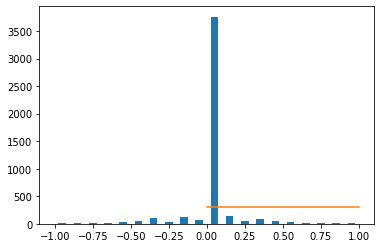

In [7]:
num_bins = 20
samples_per_bin = 300
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
print(bins)
plt.bar(center, hist, width=0.05)
plt.plot(np.min(data['steering']), np.max(data['steering']),(samples_per_bin, samples_per_bin))
np.min(data['steering'])

In [8]:
print('total data: ', len(data))
remove_list = []
for j in range(num_bins):
    bin_list = []
    for i in range(len(data['steering'])):
        if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
            bin_list.append(i)
    bin_list = shuffle(bin_list)
    bin_list = bin_list[samples_per_bin:]
    remove_list.extend(bin_list)

print('removed',len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining: ', len(data))

total data:  4633
removed 6912
remaining:  829


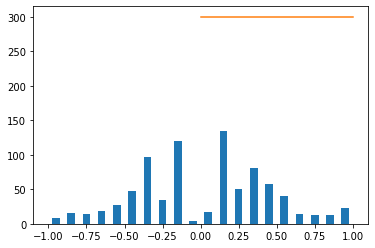

In [9]:
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot(np.min(data['steering']), np.max(data['steering']),(samples_per_bin, samples_per_bin))

In [0]:
def load_img_steering(datadir, df):
    image_path = []
    steering = []
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        center, left, right, = indexed_data[0], indexed_data[1], indexed_data[2]
        image_path.append(os.path.join(datadir, center.strip()))
        steering.append(float(indexed_data[3]))
    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)
    return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training samples: ',X_train, X_valid, y_train, y_valid);

Text(0.5, 1.0, 'Validation set')

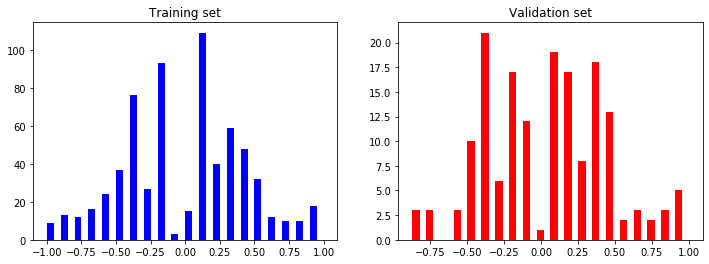

In [12]:
fig,axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].hist(y_train, bins=num_bins, width = 0.05, color='blue')
axs[0].set_title('Training set')
axs[1].hist(y_valid, bins=num_bins, width = 0.05, color='red')
axs[1].set_title('Validation set')

In [0]:
def zoom(img):
    zoom = iaa.Affine(scale=(1, 1.3))
    img = zoom.augment_image(img)
    return img

Text(0.5, 1.0, 'zoomed_image image')

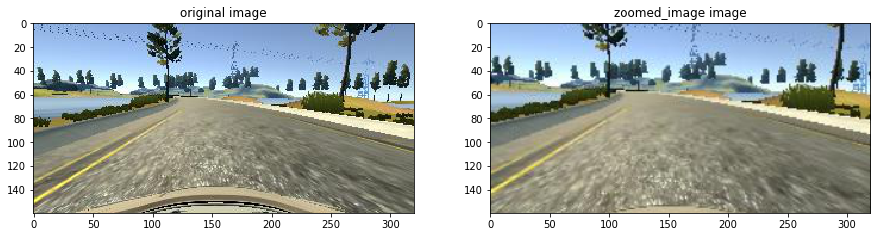

In [14]:
image_path = image_paths[random.randint(0, 650 )]
original_image = mpimg.imread(image_path)
zoomed_image = zoom(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
axs[0].imshow(original_image)
axs[0].set_title('original image')
axs[1].imshow(zoomed_image)
axs[1].set_title('zoomed_image image')

In [0]:
def pan(img):
    pan = iaa.Affine(translate_percent={'x': (-0.1,0.1), 'y': (-0.1,0.1)})
    img = pan.augment_image(img)
    return img

Text(0.5, 1.0, 'panned image')

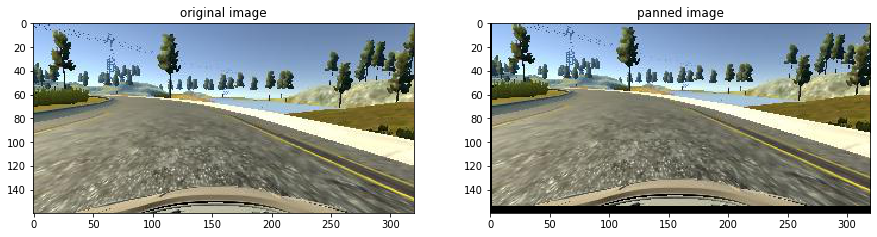

In [16]:
image_path = image_paths[random.randint(0, 650 )]
original_image = mpimg.imread(image_path)
panned_image = pan(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
axs[0].imshow(original_image)
axs[0].set_title('original image')
axs[1].imshow(panned_image)
axs[1].set_title('panned image')

In [0]:
def img_random_flip(image, steering_angle):
    image = cv2.flip(image, 1)
    steering_angle = - steering_angle
    return image, steering_angle

Text(0.5, 1.0, 'panned image, angle: 0.1694376')

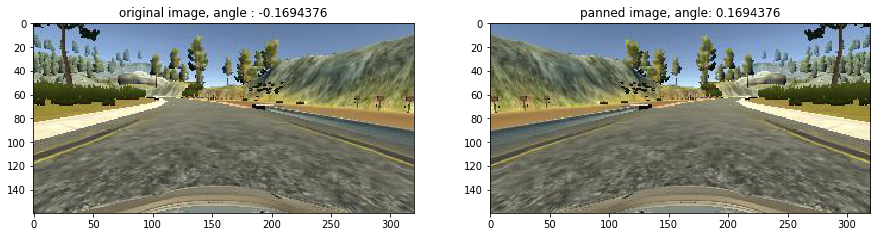

In [18]:
rand_index = random.randint(0, 650);
image_path = image_paths[rand_index]
steering = steerings[rand_index]
original_image = mpimg.imread(image_path)

flip_image, flip_steering = img_random_flip(original_image, steering)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
axs[0].imshow(original_image)
axs[0].set_title('original image, angle : '+str(steering))
axs[1].imshow(flip_image)
axs[1].set_title('panned image, angle: '+str(flip_steering))

In [0]:
def img_random_brightness(img):
    brightness = iaa.Multiply((0.2, 1.2))
    img = brightness.augment_image(img)
    return img

Text(0.5, 1.0, 'bright image')

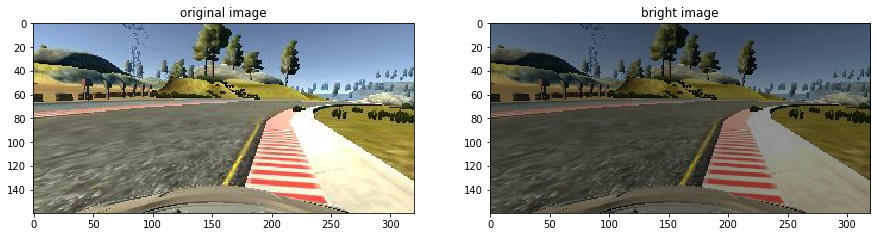

In [33]:
image_path = image_paths[random.randint(0, 650 )]
original_image = mpimg.imread(image_path)
bright_image = img_random_brightness(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
axs[0].imshow(original_image)
axs[0].set_title('original image')
axs[1].imshow(bright_image)
axs[1].set_title('bright image')

In [0]:
def random_augment(image, steering_angle):
    if np.random.rand() < 0.5:
        # print('panning')
        image = pan(image)
    if np.random.rand() < 0.5:
        # print('zooming')
        image = zoom(image)
    if np.random.rand() < 0.5:
        # print('brightenning')
        image = img_random_brightness(image)
    if np.random.rand() < 0.5:
        # print('flipping')
        image, steering_angle = img_random_flip(image, steering_angle)
    return image, steering_angle

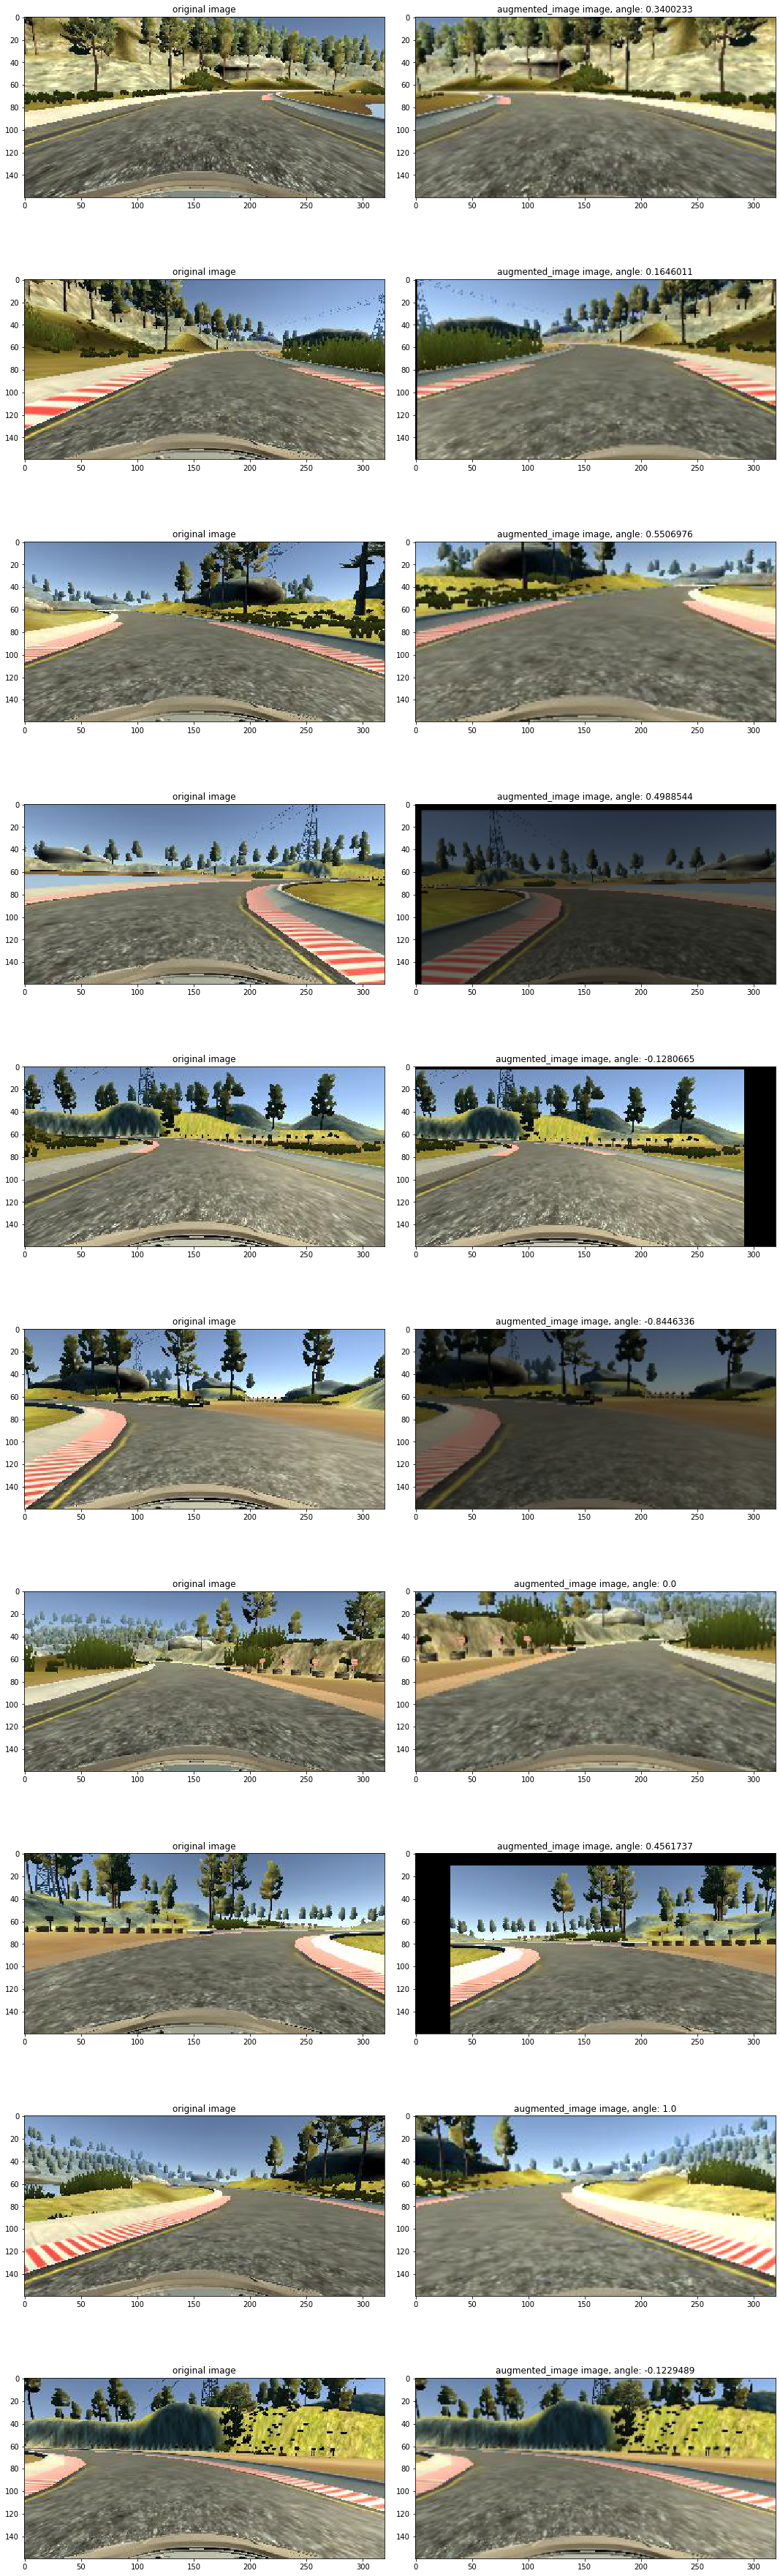

In [36]:
ncol =2
nrow = 10

fig, axs = plt.subplots(nrow, ncol, figsize=(15,50))
fig.tight_layout()

for i in range(10):
    randNum = random.randint(0, len(image_paths)-1)
    randImage = image_paths[randNum]
    randSteering = steerings[randNum]

    original_image= mpimg.imread(randImage)
    
    axs[i][0].imshow(original_image)
    axs[i][0].set_title('original image')

    augmented_image, steering = random_augment(original_image, randSteering)


    axs[i][1].imshow(augmented_image)
    axs[i][1].set_title('augmented_image image, angle: '+str(randSteering))

In [0]:
def img_preprocess(img):
    img = mpimg.imread(img)
    img = img[60:135, :, :] # strip top and bottom
    # img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3, 3), 0) # 3x3 Kernal, 0-deviation
    img = cv2.resize(img, (200, 66)) # 200x66 - Matches NVIDEA
    img = img / 255
    return img

Text(0.5, 1.0, 'preprocessed image')

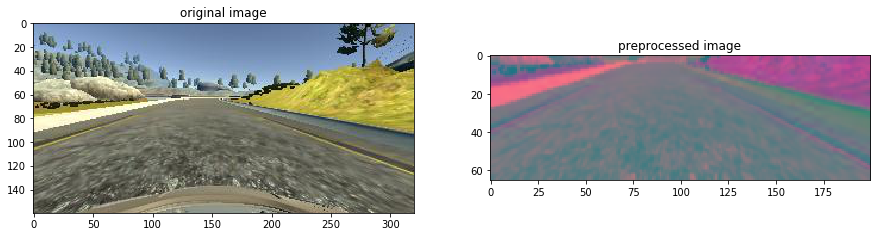

In [0]:
image_path = image_paths[100]
original_image = mpimg.imread(image_path)
preprocessed_image = img_preprocess(image_path)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
# fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('original image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('preprocessed image')

In [0]:
X_train = np.array(list(map(img_preprocess, X_train)))
X_valid = np.array(list(map(img_preprocess, X_valid)))

(676, 66, 200, 3)


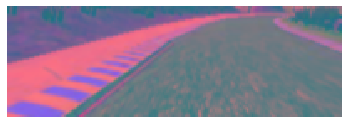

In [0]:
plt.imshow(X_train[random.randint(0, len(X_train) -1 )])
plt.axis('off')
print(X_train.shape)

In [0]:
def nvidia_model():
    model = Sequential()
    model.add(Conv2D(24, 5, 5, subsample=(2,2), input_shape=(66, 200, 3), activation='relu'))
    model.add(Conv2D(36, 5, 5, subsample=(2,2), activation='elu'))
    model.add(Conv2D(48, 5, 5, subsample=(2,2), activation='elu'))
    model.add(Conv2D(64, 3, 3, activation='elu'))
    model.add(Conv2D(64, 3, 3, activation='elu'))
    model.add(Dropout(0.5))
   
    model.add(Flatten())
    model.add(Dense(100, activation='elu'))
    model.add(Dropout(0.5))
   
    model.add(Dense(50, activation='elu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='elu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer=Adam(lr=1e-3))
    return model

In [0]:
model = nvidia_model()
print(model.summary)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

<bound method Network.summary of <keras.engine.sequential.Sequential object at 0x7f8261f28a58>>


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="relu", strides=(2, 2))`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), ac

In [0]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), batch_size=100, verbose=1, shuffle=1)




Train on 676 samples, validate on 169 samples
Epoch 1/30





676/676 [==============================] - 7s 11ms/step - loss: 0.5653 - val_loss: 0.2112
Epoch 2/30
676/676 [==============================] - 0s 320us/step - loss: 0.2321 - val_loss: 0.2060
Epoch 3/30
676/676 [==============================] - 0s 314us/step - loss: 0.1846 - val_loss: 0.2150
Epoch 4/30
676/676 [==============================] - 0s 312us/step - loss: 0.1698 - val_loss: 0.2008
Epoch 5/30
676/676 [==============================] - 0s 322us/step - loss: 0.1663 - val_loss: 0.2008
Epoch 6/30
676/676 [==============================] - 0s 327us/step - loss: 0.1649 - val_loss: 0.1958
Epoch 7/30
676/676 [==============================] - 0s 319us/step - loss: 0.1547 - val_loss: 0.1591
Epoch 8/30
676/676 [==============================] - 0s 315us/step - loss: 0.1489 - val_loss: 0.1760
Epoch 9/30
676/676 [==============================] - 0s 317us/step - loss: 0.1350 - val_loss: 0.1440
Epoch 10/30
676/676 [========

Text(0.5, 1.0, 'loss')

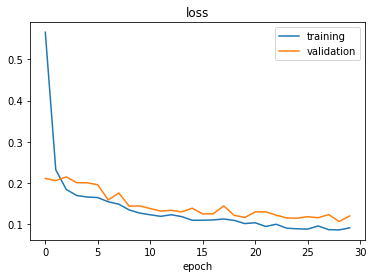

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.legend(['training', 'validation'])
plt.title('loss')

In [0]:
model.save('model.h5')

In [0]:
from google.colab import files
files.download('model.h5')